In [1]:
from openpyxl import load_workbook
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import math
import operator
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from nltk import re
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import Doc2Vec
from tqdm import tqdm
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer


## **1.1 Number of news articles for each category**

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


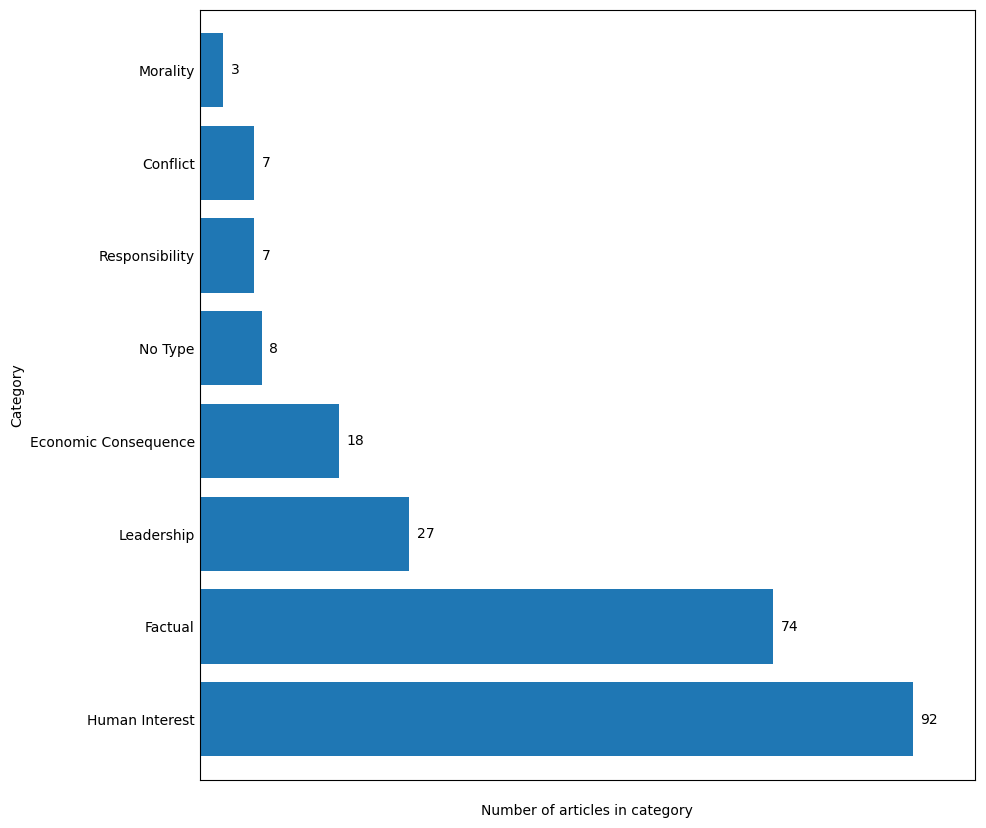

In [2]:
rd_data = pd.read_csv('/kaggle/input/news-articles-csv/data5.csv', header=0, index_col=0)
df = pd.DataFrame(rd_data)
df["label1"] = df.iloc[:, lambda df: [1, 2, 3, 4, 5, 6, 7]].values.tolist() # chose 1234567 columns of dataframe
df["label"] = df["label1"].astype(str)
df["corpus1"] = df.loc[:, ['title', 'content']].values.tolist()
df["corpus"] = df["corpus1"].astype(str)

result_data = df[['News item', 'corpus', 'label']]
result_data.loc[:,'label'] = result_data['label'].replace('[1, 0, 0, 0, 0, 0, 0]', 'Human Interest') \
    .replace('[0, 1, 0, 0, 0, 0, 0]', 'Responsibility') \
    .replace('[0, 0, 1, 0, 0, 0, 0]', 'Morality') \
    .replace('[0, 0, 0, 1, 0, 0, 0]', 'Economic Consequence') \
    .replace('[0, 0, 0, 0, 1, 0, 0]', 'Conflict') \
    .replace('[0, 0, 0, 0, 0, 1, 0]', 'Leadership') \
    .replace('[0, 0, 0, 0, 0, 0, 1]', 'Factual')\
    .replace('[0, 0, 0, 0, 0, 0, 0]', 'No Type')

result_data['label'].tolist()

result_data = result_data[result_data['label'].isin(['Human Interest', 'Responsibility', 'Morality', 'Economic Consequence', 
                                                     'Conflict', 'Leadership', 'Factual','No Type'])]
result_data.index = range(236)
result_data['corpus'].apply(lambda x: len(str(x).split(' '))).sum()

df = result_data['label'].value_counts()

plt.figure(figsize=(10,10))
ax = plt.gca()
df.plot(kind='barh',width=0.8)

cate_name = df.index
nums = df.values
cate_nums = np.arange(len(df))
for p,c,ch in zip(cate_nums,cate_name,nums):
    plt.annotate(str(ch), xy=(ch + 1, p), va = 'center')
    
ticks = plt.yticks(cate_nums, cate_name)
xt = plt.xticks()[0]
ax.tick_params(axis='both', which='both',length=0)
plt.xticks(xt,[' '] * len(xt))

plt.ylabel('Category')
plt.xlabel('Number of articles in category')
plt.show()

## **1.2 Sentence Length Distribution**

In [3]:
def add_blank(text):
    b = ''
    for index,item in enumerate(text):
        if index < len(text)-1:
            if (item == '.' or item == '?' or item == '!' or item == '…' ) and text[index + 1] != ' ':
                temp = item + ' '
                b += temp
            else:
                b+=item
    b += text[len(text)-1]
    return b

In [4]:
# data preprosessing
from string import punctuation
import re
import nltk
nltk.download('punkt')

df1 = pd.DataFrame(rd_data)
df1["corpus1"] = df1.loc[:, ['title', 'content']].values.tolist()
df1["corpus"] = df1["corpus1"].astype(str)
result_data1 = df1[['News item', 'corpus']]
result_data1.index = range(253)
result_data1['corpus'].apply(lambda x: len(str(x).split(' '))).sum()

# get each article title and content from csv file
wb1 = load_workbook(filename='/kaggle/input/news-articles/article_sheet.xlsx')  # Work Book
ws1 = wb1.get_sheet_by_name('Sheet1')  # Work Sheet
column2 = ws1['AB']  # Column
content2 = [column2[x].value for x in range(1,len(column2)-1)]



# change the format of articles in content2
contents = []
for each in content2:
    temp_text = add_blank(each)
    contents.append(temp_text)
    
from nltk import sent_tokenize
count_sen_len = []
for each in contents:
    sentence_list = sent_tokenize(each)
    length = len(sentence_list)
    count_sen_len.append(length)    
result_data1["doc_length"] = count_sen_len

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'proportion')

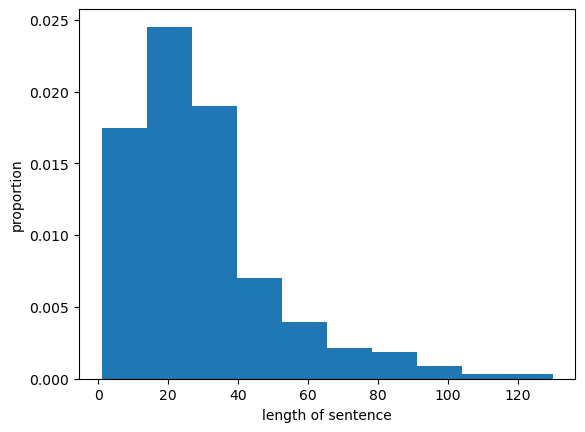

In [5]:
#直方图
plt.hist(count_sen_len,bins=None,range=None, weights=None, cumulative=False, bottom=None, 
         histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, 
         label=None, density=True,stacked=False)
plt.xlabel("length of sentence")
plt.ylabel("proportion")

## **1.3 Top 10 Most Frequent Words for Each Category**

In [6]:
category_list = ['Humanint','Responsibility','Morality','Economic Consequence','Conflict','Leadership', 
                 'Factual']

file = '/kaggle/input/news-articles/article_sheet.xlsx'
wb = load_workbook(filename = file)  # Work Book
ws = wb.get_sheet_by_name('Sheet1')  # Work Sheet

# get each article title and content from csv file
wb = load_workbook(filename='/kaggle/input/news-articles/article_sheet.xlsx')  # Work Book
ws = wb.get_sheet_by_name('Sheet1')  # Work Sheet
column = ws['AA']  # Column
title = [column[x].value for x in range(1,len(column) -1)]
column1 = ws['AB']  # Column
contents = [column1[x].value for x in range(1,len(column1)-1)]
content = []
for each in contents:
    temp_text = add_blank(each)
    content.append(temp_text)
    
corpus = []
for i in range(len(column) - 2):
    temp = ''
    temp1 = ' '
    temp += title[i]
    temp1 += content[i]
    temp2 = ''
    temp2 += temp + temp1
    corpus.append(temp2)

# get label vectors where the vectors are string
label_vectors = []
for each in range(2,255):
    temp = ''
    for i in range(20,27):
        row = ws.cell(row = each, column = i).value
        temp += str(row)
    label_vectors.append(temp)
    
find_all = lambda c, s: [x for x in range(c.find(s), len(c)) if c[x] == s]
label_category_0 = {}
count2 = 0
for each in label_vectors:
    index_all = find_all(each,'1')
    temp = []
    for per in index_all:
       temp.append(category_list[per])
    label_category_0[count2] = temp
    count2 += 1 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  # Remove the CWD from sys.path while we load stuff.


In [7]:
def get_words_frequency(corpus):
    vectorizer = CountVectorizer(#max_df = 0.8,
                                 min_df = 1,#min(0.1,5),
                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
                                 stop_words= stop_list,#'english',
                                 ngram_range = (1,2))
    X = vectorizer.fit_transform(corpus)
    A = vectorizer.get_feature_names()
    B = X.toarray().sum(axis=0)
    C = np.matrix(B)
    D = C.tolist()
    words_count_list = []
    for each in D[0]:
        words_count_list.append(each)
    words_list = []
    words_count_dic = {}
    for string in vectorizer.get_feature_names():
        if string.isdigit() == False:
            if ''.join([i for i in string if i.isdigit()]).isdigit() == False:
                index = A.index(string)
                count = words_count_list[index]
                words_count_dic[string] = count
    final_words_count_dic = sorted(words_count_dic.items(), key=lambda x: x[1], reverse=True)
    return final_words_count_dic
def get_top_n_words_fre_df(list,n):
    num = 0
    k_list = []
    v_list = []
    for word in list:  
        if num < n:
            k_list.append(word[0])
            v_list.append(word[1]) 
        num += 1
    result = pd.DataFrame({'word': k_list, "word frequency": v_list})
    return result
def get_top_n_words_fre_df(list,n):
    num = 0
    k_list = []
    v_list = []
    for word in list:  
        if num < n:
            k_list.append(word[0])
            v_list.append(word[1]) 
        num += 1
    result = pd.DataFrame({'word': k_list, "word frequency": v_list})
    return result

In [8]:
humanint = []
responsi = []
morality = []
ecocons = []
conflict = []
leadersh = []
factual = []

for each in label_category_0.keys():
    list = label_category_0[each]
    for per in list:
        if per == 'Humanint':
            humanint.append(corpus[each])
        if per == 'Responsibility':
            responsi.append(corpus[each])
        if per == 'Morality':
            morality.append(corpus[each])
        if per == 'Economic Consequence':
            ecocons.append(corpus[each])
        if per == 'Conflict':
            conflict.append(corpus[each])
        if per == 'Leadership':
            leadersh.append(corpus[each])
        if per == 'Factual':
            factual.append(corpus[each])

humanint_words_fre = get_words_frequency(humanint)
responsi_words_fre = get_words_frequency(responsi)
morality_words_fre = get_words_frequency(morality)
ecocons_words_fre = get_words_frequency(ecocons)
conflict_words_fre = get_words_frequency(conflict)
leadersh_words_fre = get_words_frequency(leadersh)
factual_words_fre = get_words_frequency(factual)
print('Human Interest')
print(get_top_n_words_fre_df(humanint_words_fre,10))
print()
print('Reponsibility')
print(get_top_n_words_fre_df(responsi_words_fre,10))
print()
print('Morality')
print(get_top_n_words_fre_df(morality_words_fre,10))
print()
print('Economic Consequence')
print(get_top_n_words_fre_df(ecocons_words_fre,10))
print()
print('Conflict')
print(get_top_n_words_fre_df(conflict_words_fre,10))
print()
print('Leadership')
print(get_top_n_words_fre_df(leadersh_words_fre,10))
print()
print('Factual')
print(get_top_n_words_fre_df(factual_words_fre,10))

NameError: name 'stop_list' is not defined

## **2.1 Frame Detection Based on Zero-shot technique**

In [ ]:
# get each article title and content from csv file
wb = load_workbook(filename='/kaggle/input/news-articles/article_sheet.xlsx')  # Work Book
ws = wb.get_sheet_by_name('Sheet1')  # Work Sheet
column = ws['AA']  # Column
title = [column[x].value for x in range(1,len(column) -1)]
column1 = ws['AB']  # Column
content = [column1[x].value for x in range(1,len(column1)-1)]
# change the format of articles in content2
# content = []
# for each in contents:
#     temp_text = add_blank(each)
#     content.append(temp_text)

# get label vectors where the vectors are string
label_vectors = []
for each in range(2,255):
    temp = ''
    for i in range(20,27):
        row = ws.cell(row = each, column = i).value
        temp += str(row)
    label_vectors.append(temp)

In [ ]:
blank_index = []
blank_seq = []
for index,item in enumerate(label_vectors):
    if item == '0000000':
        blank_index.append(index)
        blank_seq.append(1001 + index)

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
def list_txt(path, list=None):
    if list != None:
        file = open(path, 'w')
        file.write(str(list))
        file.close()
        return None
    else:
        file = open(path, 'r')
        rdlist = eval(file.read())
        file.close()
        return rdlist

In [ ]:
# merge title and content to make the corpus
corpus = []
for i in range(len(column) - 2):
    temp = ''
    temp1 = ''
    temp += title[i]
    temp1 += content[i]
    temp2 = ''
    temp2 += temp + ' ' + temp1
    corpus.append(temp2)

In [ ]:
# import stopwords and make it into a list
stopwords_path = r"/kaggle/input/stop-words/stop_words.txt"
stop_list = []
with open(stopwords_path, "r", encoding="utf-8") as f:
    for line in f.readlines():
        stop_list.append(line.replace("\n", ""))

In [ ]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin',binary=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(#max_df = 0.8,
                                 min_df = 1,#min(0.1,5),
                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
                                 stop_words= stop_list,#'english',
                                 ngram_range = (1,2))

# vectorizer = CountVectorizer(stop_words= stop_list, lowercase='True', );

X = vectorizer.fit_transform(corpus)
B = X.toarray().sum(axis=0)
C = np.matrix(B)
D = C.tolist()

feature_list = vectorizer.get_feature_names()

words_count_list = []
for each in D[0]:
    words_count_list.append(each)

words_list = []
words_count_dic = {}
for string in vectorizer.get_feature_names():
    if string.isdigit() == False:
        if ''.join([i for i in string if i.isdigit()]).isdigit() == False:
            index = feature_list.index(string)
            count = words_count_list[index]
            words_count_dic[string] = count
final_words_count_dic = sorted(words_count_dic.items(), key=lambda x: x[1], reverse=True)

words_list = []
num = 0
for each in final_words_count_dic:
     words_list.append(each[0])

use_words_list = [] 
matrix = 0
for each in words_list:
        if w2v_model.has_index_for(each):
            use_words_list.append(each)

In [ ]:
result = w2v_model[use_words_list[0]].reshape(1,300)
num = 0
final_use_words_list = []
final_use_words_list.append(use_words_list[0])
for each in use_words_list[1:]:
    if num < 5000 - 1:
        result = np.r_[result,w2v_model[each].reshape(1,300)]
        final_use_words_list.append(each)
        num += 1
w2v_array = np.array(result)

In [ ]:
outcome = model.encode(final_use_words_list[0]).reshape(1,768)
for each in final_use_words_list[1:]:
        outcome = np.r_[outcome,model.encode(each).reshape(1,768)]

sb_array  = np.array(outcome)

In [ ]:
import torch
import torch.nn.functional as F

def OLS_with_l2_regularization(
    X: torch.Tensor, Y: torch.Tensor, alpha: float = 0
) -> torch.Tensor:
    """Computes ordinary least squares

    Ordinary least squares with l2 regularization can be expressed in closed form,
    meaning that we do not need to perform gradient descent in order
    to find the best fit solution!
    For more information on the derivation of the closed-form expression,
    check it the Wikipedia page here:
    https://en.wikipedia.org/wiki/Ordinary_least_squares#Matrix/vector_formulation

    In brief: we find a matrix, w, that transforms X to Y according to:

    Y = Xw

    (X.T X)^-1 X.T Y = [(X.T X)^-1 X.T X]w

    w = (X.T X + alpha*I)^-1 X.T Y

    where I is the identity matrix and alpha is the amount of regularization.
    alpha = 0 is equivalent to OLS (ordinary least squares)
    alpha >= 0 is ridge regression / l2 regularization
    """
    X_norm = F.normalize(X, p=2, dim=1)
    Y_norm = F.normalize(Y, p=2, dim=1)
    I = torch.eye(X_norm.shape[1])

    inner = torch.matmul(X_norm.T, X_norm) + alpha * I
    Z = torch.inverse(inner)
    Z = torch.matmul(Z, X_norm.T)
    w = torch.matmul(Z, Y_norm)

    return w

In [ ]:
tensor_S = torch.Tensor(sb_array)
tensor_W = torch.Tensor(w2v_array)
Zmap = OLS_with_l2_regularization(tensor_S, tensor_W)
Zmap = Zmap.numpy()

In [ ]:
# get each article using sentenceBert embedding as well as Zmap
from nltk import sent_tokenize
count = 1001
article_sb = {}
article_sb_with_Zmap = {}
for each in content:
    sentence_list = sent_tokenize(each)
    result = model.encode(sentence_list[0]).reshape(1,768)
    for per in sentence_list[1:]:
        result += model.encode(per).reshape(1,768)
    result_0 = result/len(sentence_list)
    result_1 = np.dot(result_0,Zmap)
    article_sb[count] = result_0
    article_sb_with_Zmap[count] = result_1
    count += 1

In [ ]:
category_list = ['Human Interest','Responsibility','Morality','Economic Consequence','Conflict','Leadership', 'Factual']

categories_sb = {}
categories_w2v = {}
# get category embedding using SentenceBert 
for category in category_list:
    result = model.encode(category).reshape(1,768)
    categories_sb[category] = result
    
# import category embedding using w2v which has been already made
categories_w2v['Responsibility'] = np.dot(model.encode('responsibility').reshape(1,768),Zmap)
categories_w2v['Morality'] = np.dot(model.encode('morality').reshape(1,768),Zmap)
categories_w2v['Conflict'] = np.dot(model.encode('conflict').reshape(1,768),Zmap)
categories_w2v['Leadership'] = np.dot(model.encode('leadership').reshape(1,768),Zmap)
categories_w2v['Factual'] = np.dot(model.encode('factual').reshape(1,768),Zmap)
categories_w2v['Human Interest'] = np.dot(model.encode('Human Interest').reshape(1,768),Zmap)
categories_w2v['Economic Consequence'] = np.dot(model.encode('Economic Consequence').reshape(1,768),Zmap)

find_all = lambda c, s: [x for x in range(c.find(s), len(c)) if c[x] == s]
label_category = {}
count2 = 1001
for each in label_vectors:
    index_all = find_all(each,'1')
    temp = []
    for per in index_all:
        temp.append(category_list[per])
    label_category[count2] = temp
    count2 += 1 

In [ ]:
# calculate cos similarity between category vector and article vector, predict category using sentenceBert embeddings only
from sklearn.metrics.pairwise import cosine_similarity
frame_sb = {}
count1 = 1001
categories_sb_prediction = {}
score_sb = []
score_sb_Zmap = []

for each in article_sb.keys():
     temp_score = {}
     max = cosine_similarity(article_sb[each].reshape(1, -1), categories_sb['Human Interest'].reshape(1, -1))
     categories_sb_prediction[count1] = 'Human Interest'
     for per in categories_sb:
            temp = cosine_similarity(article_sb[each].reshape(1, -1), categories_sb[per].reshape(1, -1))  
            temp_score[per] = temp[0].tolist()[0]
            if temp > max:
                max = temp
                categories_sb_prediction[count1] = per
     score_sb.append(temp_score)
     count1 += 1

# get accuracy of sentenceBert only
correct = 0
for each in categories_sb_prediction:
    if  each not in blank_seq and categories_sb_prediction[each] in label_category[each]:
        correct += 1

# calculate cos similarity between category vector and article vector, predict category using sentenceBert with Zmap
frame_sb_with_Zmap = {}
count3 = 1001
categories_sb_with_Zmap_prediction = {}
for each in article_sb_with_Zmap.keys():
     temp_score = {}
     max = cosine_similarity(article_sb_with_Zmap[each].reshape(1, -1), categories_w2v['Human Interest'].reshape(1, -1))
     categories_sb_with_Zmap_prediction[count3] = 'Human Interest'
     for per in categories_w2v:
            temp = cosine_similarity(article_sb_with_Zmap[each].reshape(1, -1), categories_w2v[per].reshape(1, -1))
            temp_score[per] = temp[0].tolist()[0]
            if temp > max:
                max = temp
                categories_sb_with_Zmap_prediction[count3] = per
     score_sb_Zmap.append(temp_score)
     count3+= 1

# get accuracy of sentenceBert with Zmap
correct1 = 0
for each in categories_sb_with_Zmap_prediction:
    if  each not in blank_seq and categories_sb_with_Zmap_prediction[each] in label_category[each]:
        correct1 += 1

In [ ]:
print("Accuracy for sentenceBert only: ",correct/(len(content) - len(blank_seq)))
print("Accuracy for sentenceBert*Zmap: ",correct1/(len(content) - len(blank_seq)))

In [9]:
# visualize the result of zero-shot technique
x_data = [f"SentenceBert",f"SentenceBert*Zmap"]
y_data = [correct/(len(content) - len(blank_seq)) * 100,correct1/(len(content) - len(blank_seq))*100]

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(6,6))
for i in range(len(x_data)):
    plt.bar(x_data[i], y_data[i],width=0.6, bottom=None)
plt.ylabel("Accuracy")
plt.show()

NameError: name 'correct' is not defined

## **2.2 Confusion Matrix**

In [ ]:
category_prediction = []
for each in categories_sb_prediction:
    string = categories_sb_prediction[each]
    index = category_list.index(string)
    category_prediction.append(index)

In [ ]:
category_Zmap_prediction = []
for each in categories_sb_with_Zmap_prediction:
    string = categories_sb_with_Zmap_prediction[each]
    index = category_list.index(string)
    category_Zmap_prediction.append(index)

In [ ]:
find_all = lambda c, s: [x for x in range(c.find(s), len(c)) if c[x] == s]
category_label = []
for each in label_vectors:
    index_all = find_all(each,'1')
    category_label.append(index_all)
    count2 += 1 

In [ ]:
category_true = []
for each in category_label:
    if len(each) == 1:
        category_true.append(each[0])
    else:
        category_true.append(-1)
        
number = 0
double_index = []
for per in category_label:
    if len(per) == 2:
        double_index.append(number)
    number += 1

pop_index = blank_index + double_index
pop_index.sort()
pop_index.reverse()

for i in pop_index:
        category_true.pop(i)
        category_prediction.pop(i)
        category_Zmap_prediction.pop(i)

Sentence Bert Only

0: Human Interest,1: Responsibility, 2: Morality, 3: Economic Consequence, 4: Conflict, 5: Leadership, 6: Factual

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(category_true, category_prediction,labels=[0,1,2,3,4,5,6])
cm_display = ConfusionMatrixDisplay(cm).plot()

Sentence Bert * Zmap

0: Human Interest,1: Responsibility, 2: Morality, 3: Economic Consequence, 4: Conflict, 5: Leadership, 6: Factual

In [ ]:
cm = confusion_matrix(category_true, category_Zmap_prediction,labels=[0,1,2,3,4,5,6])
cm_display = ConfusionMatrixDisplay(cm).plot()